<a href="https://colab.research.google.com/github/jinsingsangsung/ControllableGarmentTransfer/blob/master/DL_InterClothGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#InterClothGAN

#intro
InterClothGAN is an application of the paper ['Interpreting the Latent Space of GANs for Semantic Face Editing'](https://arxiv.org/pdf/1907.10786.pdf) in a different domain, fasion. The original project page can be found [here](https://genforce.github.io/interfacegan/). This code is inpired and edited from [interFaceGan's colab notebook](https://colab.research.google.com/github/genforce/interfacegan/blob/master/docs/InterFaceGAN.ipynb#scrollTo=ijKTlG5GeTd3 ).

In [ ]:
!git clone https://github.com/tcabezon/InterClothGAN.git

In [ ]:
cd InterClothGAN/

In [ ]:
!wget https://www.dropbox.com/s/yy0lh3pnje4tb5c/viton10k-005000_pytorch.pth?dl=0 -O models/pretrain/viton10k-005000_pytorch.pth --quiet

#code

> Load Model





In [ ]:
#@title { display-mode: "form", run: "auto" }

import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate

def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed) #to be able to reproduce results
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))


model_name = "stylegan_viton10k" 
latent_space_type = "W" 

generator = StyleGANGenerator(model_name)

ATTRS = ['sleeves','red','texture']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundaries[attr_name] = np.load(f'viton10k_boundaries/{attr_name}.npy')

[2022-04-30 19:05:52,348][INFO] Loading pytorch model from `models/pretrain/viton10k-005000_pytorch.pth`.
[2022-04-30 19:05:52,657][INFO] Successfully loaded!
[2022-04-30 19:05:52,658][INFO]   `lod` of the loaded model is 0.0.


> Generate image

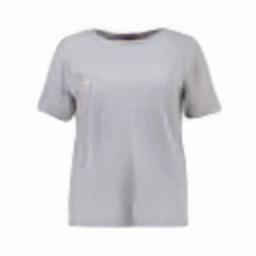

In [ ]:
#@title { display-mode: "form", run: "auto" }

num_samples = 2
noise_seed = 522 #@param {type:"slider", min:44, max:1000, step:239}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)[1,:]
latent_codes =latent_codes [np.newaxis,:]
num_samples = 1
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

> Edit image!

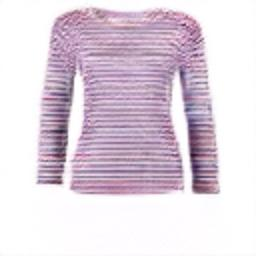

In [ ]:
#@title { display-mode: "form", run: "auto" }

sleeves = 1 #@param {type:"slider", min:-1.0, max:2.0, step:0.1}
red = 1.5 #@param {type:"slider", min:-1.0, max:2.0, step:0.1}
texture = 2.4 #@param {type:"slider", min:-3.0, max:5.0, step:0.1}


new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)